In [1]:
import numpy as np
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import itertools

In [2]:
nodes_gpd = gpd.read_file('./wegengraaf2/points.shp')
lines_gpd = gpd.read_file('./wegengraaf2/lines.shp')

In [3]:
nodes_gpd[nodes_gpd['nodeID'] == 135]

,x,y,nodeID,stad_naam,is_auto_br,spawn_hoev,geometry
123,605283.496567,7.015165e+06,135.0,None,NaN,NaN,POINT (605283.497 7015164.9)


In [4]:
gf = nx.Graph()

for _, k in nodes_gpd.iterrows():
    gf.add_node(int(k['nodeID']),
                x=k['geometry'].x,
                y=k['geometry'].y,
                stad_naam=k['stad_naam'],
                is_auto_br=k['is_auto_br'],
                spawn_hoev=k['spawn_hoev'])

for _, row in lines_gpd.iterrows():
    gf.add_edge(int(row['node_start']), int(row['node_end']),
                wegnr=row['wegnr'],
                length=row['length'],
                maxshd=row['maxshd'],
                nbanen=row['nbanen'])
    
gfd = nx.DiGraph(gf)

In [5]:
def weight_edge_min(f, t, attr):
    return attr['length']/attr['maxshd']/1000*60

def weight_edge_dist(f, t, attr):
    return attr['length']

In [6]:
%%time
dist = {}
paths = {}

for (n, (a, b)) in nx.all_pairs_dijkstra(gfd, weight=weight_edge_min):
    dist[n] = a
    paths[n] = b

CPU times: total: 141 ms
Wall time: 131 ms


### shortest path examples

In [7]:
from_node = 1000
to_node = 502
show_shortest_paths = 1

In [8]:
(pair_dist, pair_path) = nx.single_source_dijkstra(gfd, from_node, to_node, weight=weight_edge_min)
print(pair_dist, pair_path)

31.76181368523101 [1000, 175, 253, 254, 197, 169, 168, 167, 189, 234, 233, 149, 1003, 503, 502]


In [9]:
list_shortest = itertools.islice(nx.shortest_simple_paths(gfd, from_node, to_node, weight=weight_edge_min),
                                 show_shortest_paths)
list_shortest = list(list_shortest)

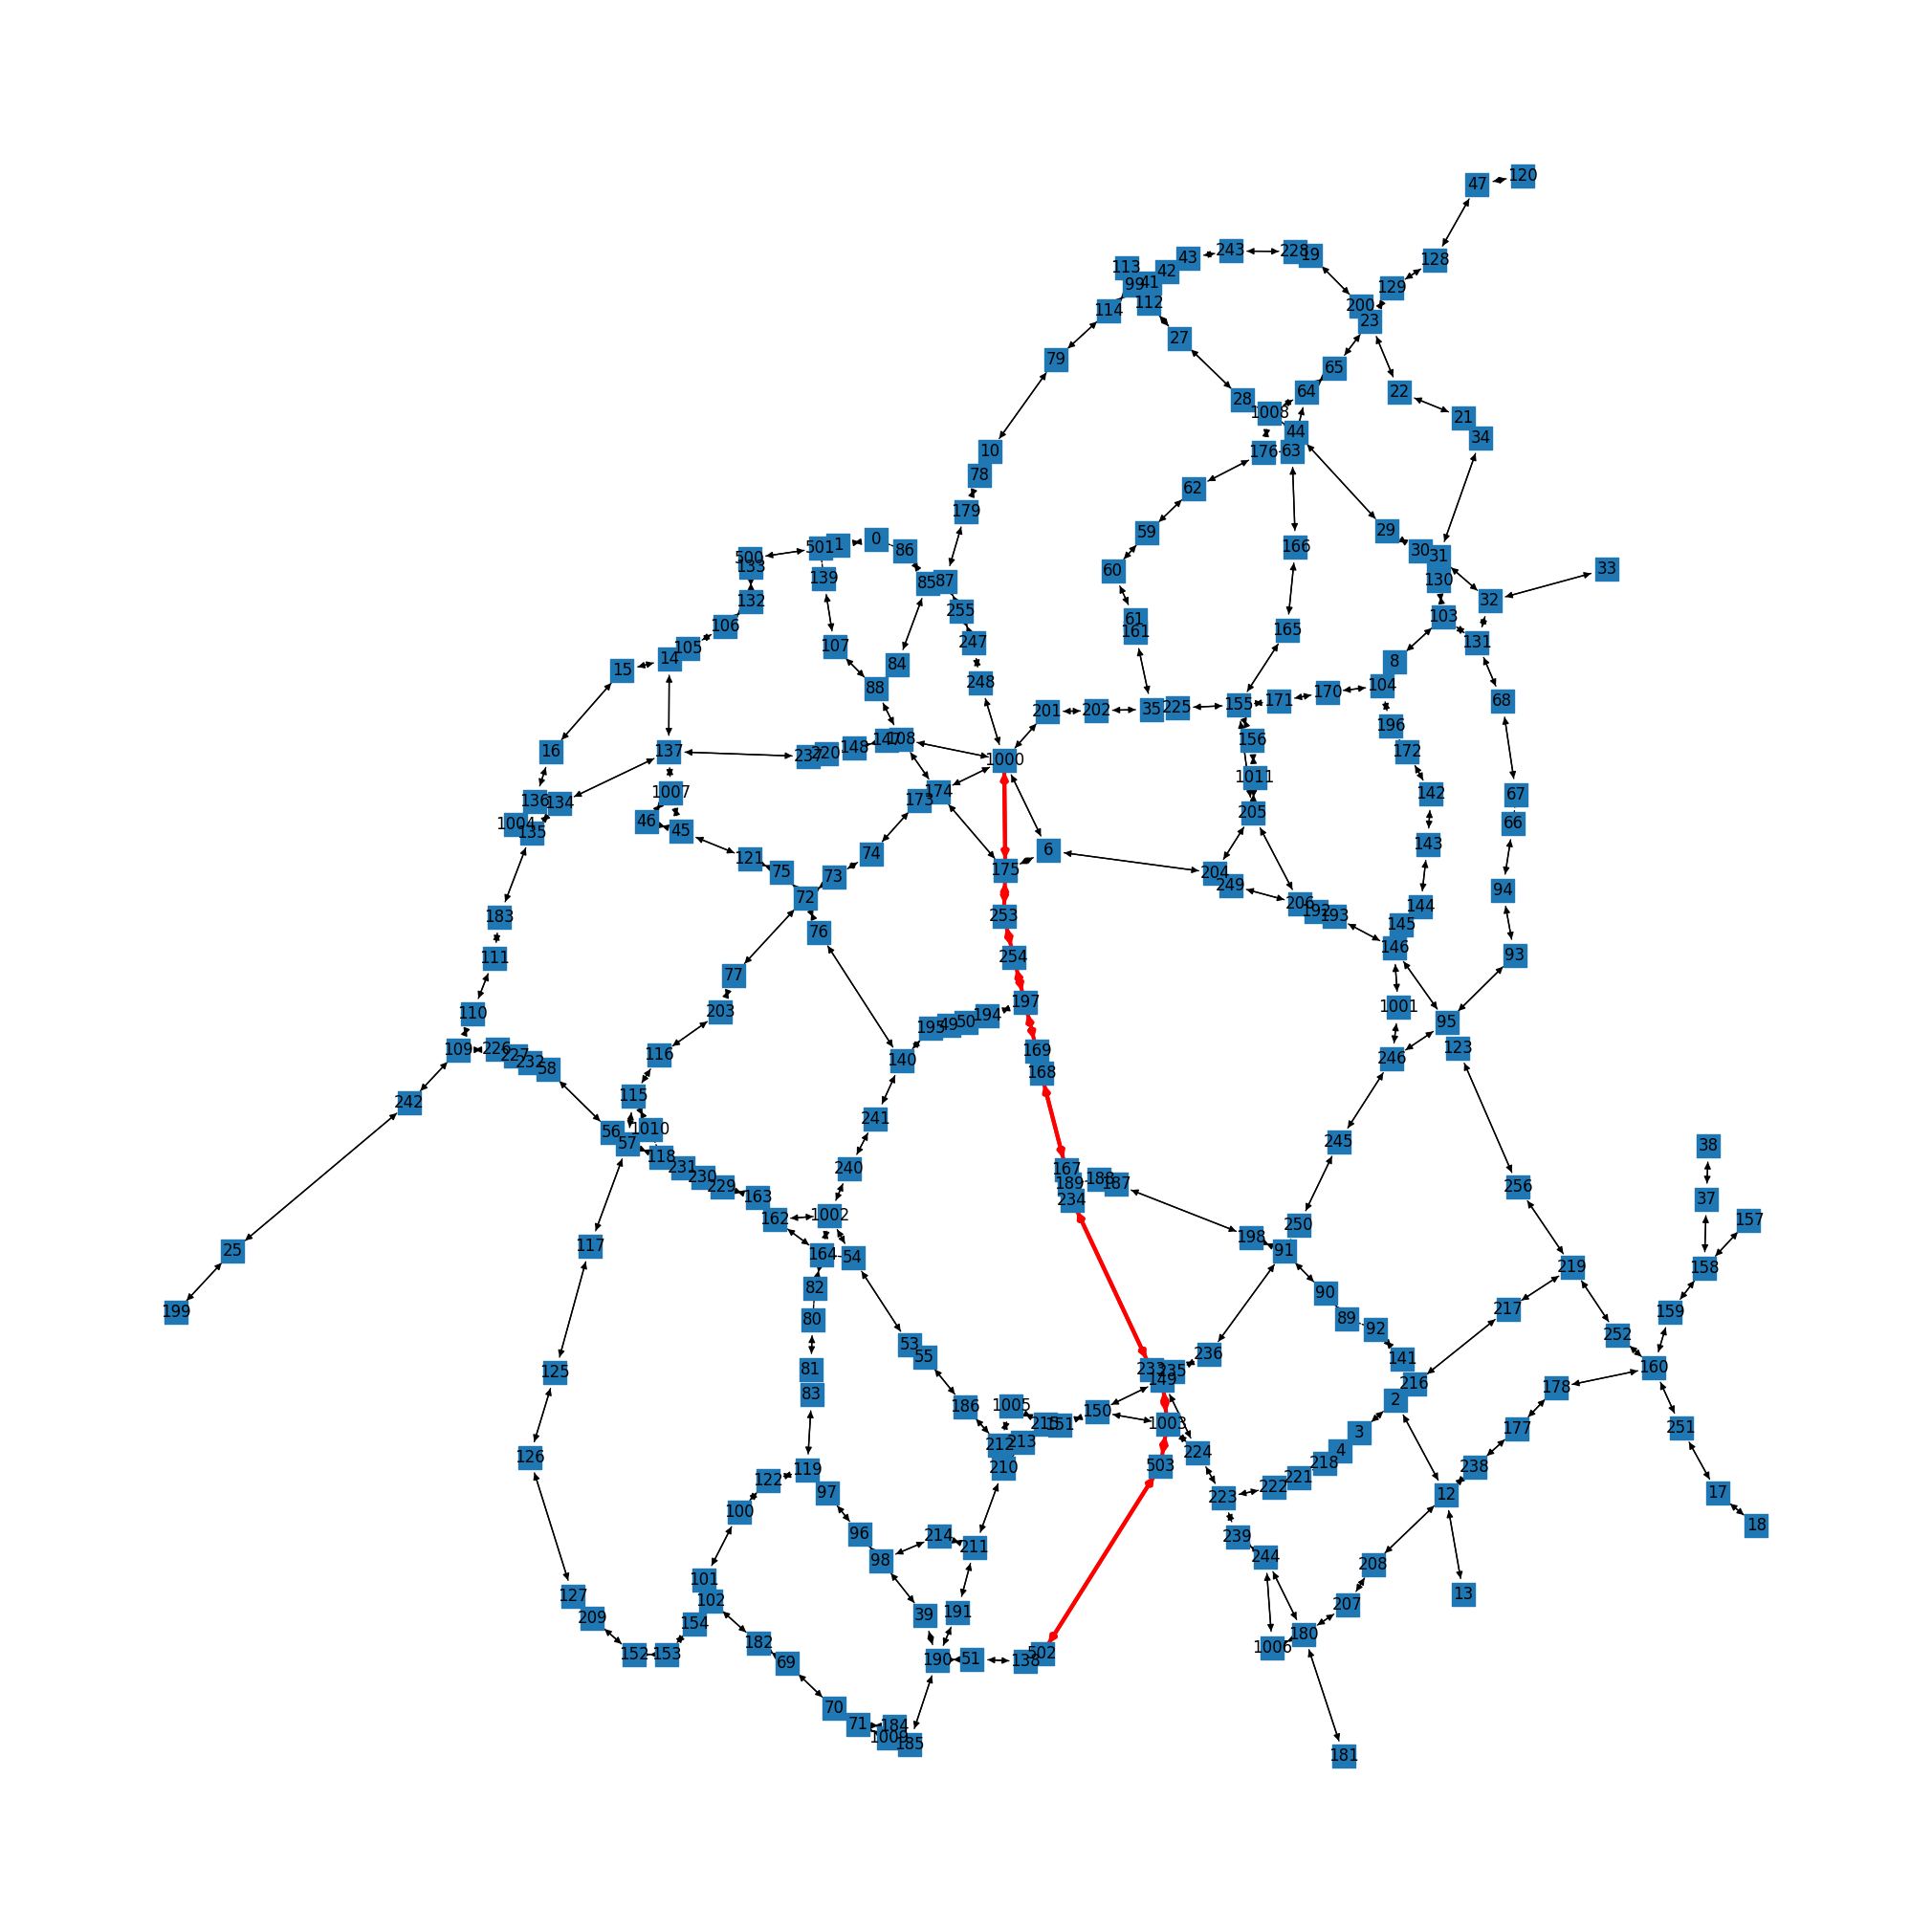

In [10]:
plt.figure(figsize=(20, 20))
nx.draw(gfd, pos={n: [gfd.nodes[n]['x'], gfd.nodes[n]['y']] for n in list(gfd.nodes)}, with_labels=True, node_shape='s')

i = 0
colors = ['red', 'green', 'magenta', 'darkblue', 'yellow']
style = ['-', '--', '-.', '--', '--']
for path in list_shortest:
    subgr = nx.DiGraph(gfd.subgraph(path))
    nx.draw_networkx_edges(subgr, pos={n: [gfd.nodes[n]['x'], gfd.nodes[n]['y']] for n in list(gfd.nodes)},
                           edge_color=colors[i], width=3, style=style[i])
    i += 1

plt.show()